
##Load Data
Loading data is the initial step in a machine learning workflow, involving the retrieval and preparation of datasets. This process includes splitting the data into training and validation sets and applying necessary preprocessing to ensure the data is in a usable format for model training and evaluation.

In [ ]:
#Install Libraries
!pip install transformers datasets
!pip install tensorflow transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.3 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from datasets import load_dataset
from datasets import load_metric
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, TFAutoModelForSequenceClassification, AutoTokenizer


In [5]:
# Load Data
def load_and_preprocess_data(dataset_name, test_size=0.2, seed=42):
    """
    Load and preprocess the dataset.
    Processed training and validation datasets.
    """
    ds = load_dataset(dataset_name)
    split_ds = ds['train'].train_test_split(test_size=test_size, seed=seed)
    train_df = split_ds['train'].to_pandas()
    val_df = split_ds['test'].to_pandas()
    return train_df, val_df

train_df, val_df = load_and_preprocess_data("SetFit/amazon_reviews_multi_de")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Repo card metadata block was not found. Setting CardData to empty.


Generating train split:   0%|          | 0/200000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5000 [00:00<?, ? examples/s]

##Exploratory Data Analysis (EDA)
The eda_plot_distribution function visualizes the label distributions in the training and validation datasets by generating side-by-side bar charts. It uses Seaborn's countplot to display the count of each label, providing a clear comparison between the two datasets. The function is designed to quickly identify any imbalances or discrepancies in label distribution, which are critical to assess before model training. After defining the function, can call it with train_df and val_df to generate the plots and visually inspect the label distributions.

<ipython-input-6-aa24c99a6698>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='label', palette='rocket')
<ipython-input-6-aa24c99a6698>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=val_df, x='label', palette='rocket')


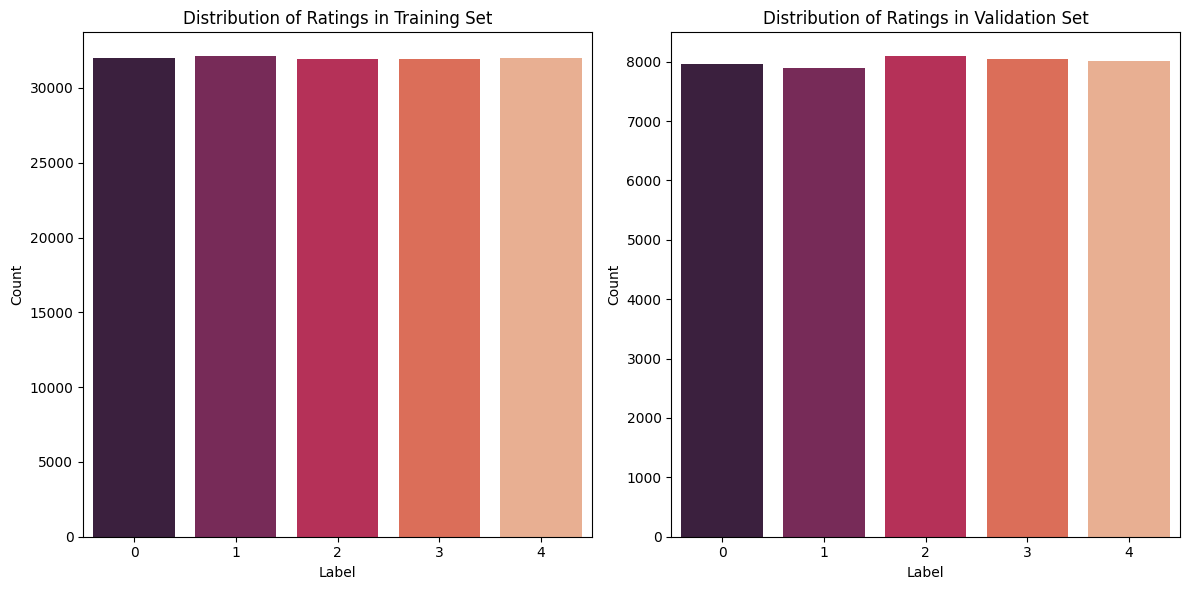

In [6]:
def eda_plot_distribution(train_df, val_df):
    """
    Plot the distribution of labels in the training and validation datasets side by side.
    train_df: The DataFrame containing the training data.
    val_df: The DataFrame containing the validation data.
    """
    plt.figure(figsize=(12, 6))

    # Subplot for Training Set
    plt.subplot(1, 2, 1)
    sns.countplot(data=train_df, x='label', palette='rocket')
    plt.title('Distribution of Ratings in Training Set')
    plt.xlabel('Label')
    plt.ylabel('Count')

    # Subplot for Validation Set
    plt.subplot(1, 2, 2)
    sns.countplot(data=val_df, x='label', palette='rocket')
    plt.title('Distribution of Ratings in Validation Set')
    plt.xlabel('Label')
    plt.ylabel('Count')

    # Show the plots
    plt.tight_layout()
    plt.show()

# Example usage
eda_plot_distribution(train_df, val_df)

##Preprocessing
Preprocessing Methods like Dropping Features, Encodingand Imputation to smooth the structure of dataset and enhace/ accelerate the performance of the Model

In [8]:
# Drop unnecessary columns
train_df = train_df.drop(columns=['id', 'label_text'])
val_df = val_df.drop(columns=['id', 'label_text'])

In [9]:
# Convert numerical ratings to sentiments
def convert_to_sentiment(label):
    if label in [1, 2]:
        return 'Negative'
    elif label == 3:
        return 'Neutral'
    elif label in [4, 5]:
        return 'Positive'

train_df['sentiment'] = train_df['label'].apply(convert_to_sentiment)
val_df['sentiment'] = val_df['label'].apply(convert_to_sentiment)

In [10]:
#check for null values.
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       160000 non-null  object
 1   label      160000 non-null  int64 
 2   sentiment  127968 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


In [13]:
# Impute missing labels with the mode (most frequent label)
train_mode_label = train_df['sentiment'].mode()[0]
val_mode_label = val_df['sentiment'].mode()[0]

# Replace NaN values in sentiment column with the mode
train_df['sentiment'].fillna(train_mode_label, inplace=True)
val_df['sentiment'].fillna(val_mode_label, inplace=True)

##Training and Fine-Tuning Model
In this training and fine-tuning process, a pre-trained BERT model (bert-base-german-cased) was loaded for sentiment classification, and the corresponding tokenizer was used to preprocess the text data. The text data was tokenized, and the sentiments were mapped to numerical labels. These were then converted into TensorFlow datasets, batched for efficient processing. The model was compiled using the Adam optimizer and sparse categorical cross-entropy loss, with accuracy as the evaluation metric. A checkpoint callback was set up to save model weights during training. Finally, the model was fine-tuned for three epochs on the training dataset, with validation on a separate validation set.


In [15]:
# Load the BERT model and tokenizer
model_name = 'bert-base-german-cased'
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/255k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/485k [00:00<?, ?B/s]

In [16]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Tokenize the text data
train_encodings = tokenizer(train_df['text'].tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_df['text'].tolist(), truncation=True, padding=True, max_length=128)


In [17]:
# Map sentiments to numerical labels
sentiment_to_label = {'Negative': 0, 'Neutral': 1, 'Positive': 2}

# Convert sentiments to numeric labels
train_labels = train_df['sentiment'].map(sentiment_to_label).values
val_labels = val_df['sentiment'].map(sentiment_to_label).values

# Convert labels to TensorFlow tensors
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.int32)
val_labels = tf.convert_to_tensor(val_labels, dtype=tf.int32)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels))

# Batch the datasets
train_dataset = train_dataset.shuffle(len(train_dataset)).batch(16)
val_dataset = val_dataset.batch(16)

In [18]:
# Compile the model with Keras
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


In [19]:
# Create a callback that saves the model's weights
checkpoint_path="model_checkpoints/cp-{epoch:04d}.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [20]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3,
    callbacks=[cp_callback]
)


Epoch 1/3
10000/10000 [==============================] - ETA: 0s - loss: 0.5137 - accuracy: 0.7862
Epoch 1: saving model to model_checkpoints/cp-0001.ckpt
10000/10000 [==============================] - 802s 76ms/step - loss: 0.5137 - accuracy: 0.7862 - val_loss: 0.4868 - val_accuracy: 0.8028
Epoch 2/3
10000/10000 [==============================] - ETA: 0s - loss: 0.4588 - accuracy: 0.8100
Epoch 2: saving model to model_checkpoints/cp-0002.ckpt
10000/10000 [==============================] - 719s 72ms/step - loss: 0.4588 - accuracy: 0.8100 - val_loss: 0.4776 - val_accuracy: 0.8023
Epoch 3/3
10000/10000 [==============================] - ETA: 0s - loss: 0.4289 - accuracy: 0.8227
Epoch 3: saving model to model_checkpoints/cp-0003.ckpt
10000/10000 [==============================] - 718s 72ms/step - loss: 0.4289 - accuracy: 0.8227 - val_loss: 0.4838 - val_accuracy: 0.8049


##Evaluate Model
In the model evaluation process, the fine-tuned BERT model was assessed on the validation dataset, yielding a validation accuracy metric. The model's performance was then printed, and the model itself was saved for future use. Additionally, the training history was plotted to visualize both the loss and accuracy over the epochs for the training and validation datasets. This provided insight into the model's learning behavior, highlighting how well it generalized to unseen data during training.

In [21]:
# Evaluate the model
loss, accuracy = model.evaluate(val_dataset)
print(f'Validation Accuracy: {accuracy}')


2500/2500 [==============================] - 72s 29ms/step - loss: 0.4838 - accuracy: 0.8049
Validation Accuracy: 0.8048999905586243


In [22]:
# Save the model
model.save('bert_sentiment_model')


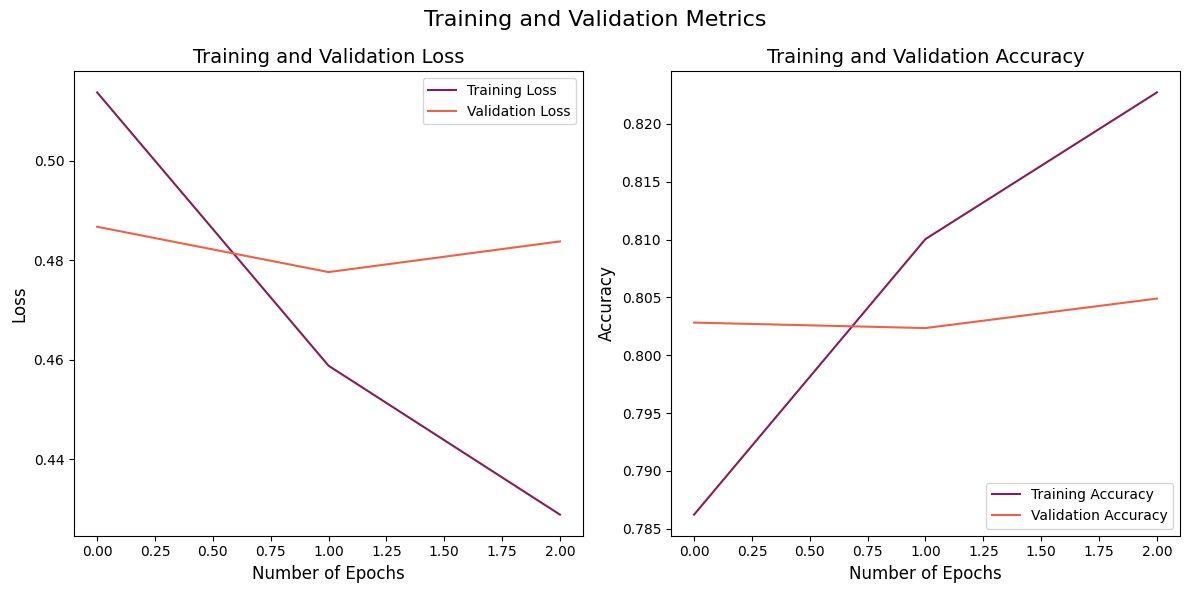

In [31]:
# Plot Training History
def plot_training_history(history):
    """
    Plot the training and validation metrics.

    Args:
    history: Training history.
    """
    # Get the number of epochs
    epochs_range = range(len(history.history['loss']))

    # Use the 'rocket' color palette
    palette = sns.color_palette("rocket", 2)

    # Plot the training history
    plt.style.use('default')
    plt.figure(figsize=(12, 6))

    # Set the main title for the figure
    plt.suptitle("Training and Validation Metrics", fontsize=16)

    # Plot the Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history.history['loss'], label='Training Loss', color=palette[0])
    plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss', color=palette[1])
    plt.xlabel('Number of Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(loc='upper right', fontsize=10)
    plt.title('Training and Validation Loss', fontsize=14)

    # Plot the Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy', color=palette[0])
    plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy', color=palette[1])
    plt.xlabel('Number of Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(loc='lower right', fontsize=10)
    plt.title('Training and Validation Accuracy', fontsize=14)

    plt.tight_layout()
    plt.show()

plot_training_history(history)


##Prediction
In the prediction phase, a function predict_sentiment was defined to classify the sentiment of a given text input. This function tokenizes the input text using the pre-trained tokenizer, then passes it through the BERT model to obtain logits, which are converted to probabilities using softmax. The predicted sentiment label is determined by finding the index with the highest probability, which is then mapped to the corresponding sentiment using a predefined label mapping. The function was tested with three example texts representing positive, negative, and neutral sentiments, and the results—including predicted sentiments and associated probabilities—were printed for each text to demonstrate the model’s capability to handle various sentiment scenarios.

In [27]:
# Define the correct mapping from numeric labels to sentiment labels
label_to_sentiment = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

# Function to make a prediction on a single text input
def predict_sentiment(text):
    # Tokenize the input text
    inputs = tokenizer(text, truncation=True, padding=True, max_length=128, return_tensors="tf")

    # Get the model's predictions (logits)
    outputs = model(inputs)
    logits = outputs.logits

    # Convert logits to probabilities (optional)
    probs = tf.nn.softmax(logits, axis=-1)

    # Get the predicted label
    predicted_label = tf.argmax(probs, axis=1).numpy()[0]

    # Map the predicted label to the corresponding sentiment
    predicted_sentiment = label_to_sentiment[predicted_label]

    return predicted_sentiment, probs.numpy()

# Example usage
text = "Das Produkt ist hervorragend und von sehr guter Qualität!"
predicted_sentiment, probabilities = predict_sentiment(text)

print(f"Predicted Sentiment: {predicted_sentiment}")
print(f"Probabilities: {probabilities}")


Predicted Sentiment: Positive
Probabilities: [[0.01187012 0.11737423 0.8707556 ]]


In [28]:
# text 1: Positive sentiment
text1 = "Ich bin sehr zufrieden mit dem Produkt, es hat meine Erwartungen übertroffen!"
predicted_sentiment1, probabilities1 = predict_sentiment(text1)
print(f"Text: {text1}")
print(f"Predicted Sentiment: {predicted_sentiment1}")
print(f"Probabilities: {probabilities1}\n")

# text 2: Negative sentiment
text2 = "Das Produkt ist enttäuschend, es ist von schlechter Qualität."
predicted_sentiment2, probabilities2 = predict_sentiment(text2)
print(f"Text: {text2}")
print(f"Predicted Sentiment: {predicted_sentiment2}")
print(f"Probabilities: {probabilities2}\n")

# text 3: Neutral sentiment
text3 = "Das Produkt ist in Ordnung, aber es gibt bessere Alternativen."
predicted_sentiment3, probabilities3 = predict_sentiment(text3)
print(f"Text: {text3}")
print(f"Predicted Sentiment: {predicted_sentiment3}")
print(f"Probabilities: {probabilities3}\n")


Text: Ich bin sehr zufrieden mit dem Produkt, es hat meine Erwartungen übertroffen!
Predicted Sentiment: Positive
Probabilities: [[0.01294035 0.16478054 0.82227916]]

Text: Das Produkt ist enttäuschend, es ist von schlechter Qualität.
Predicted Sentiment: Negative
Probabilities: [[9.9448556e-01 4.7738333e-03 7.4057590e-04]]

Text: Das Produkt ist in Ordnung, aber es gibt bessere Alternativen.
Predicted Sentiment: Negative
Probabilities: [[0.8446369  0.14559    0.00977299]]

